<a href="https://colab.research.google.com/github/Prang-nin/house_price_prediction_using_NN/blob/main/House_Price_Prediction_Using_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SECTION I : INTRODUCTION**
## **Objective** 🏡
To predict house sale prices in King Country, USA.

**The Data set can be download**

👉 https://www.kaggle.com/datasets/harlfoxem/housesalesprediction

## **Table of contents** ✍

**Pre-processing** 🔰

- Load the dataset 
- Import modules and libraries
- Data visualization
- Features engineer
- Train and test splitting 
- Features normalization

**Train models**  ⌛
- Model creation
- Hyperparameters Tuning

**Evaluate  Models** 🔔
- Comparison of the evaluation of each parameters configuation
- Plot the result for each method and parameter

**Reference**
- Auther and co-auther

# **SECTION II : DATA-PREPROCESSING**
## **1. Load the dataset** ⏩

In [5]:
import pandas as pd
import io
from google.colab import files
uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['kc_house_data.csv']))

Saving kc_house_data.csv to kc_house_data (1).csv


## **2. Import modules**

In [6]:
# import nescessary modules
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.metrics import mean_absolute_error,mean_squared_error,explained_variance_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate


## **3. Data visualization**

In [ ]:
# check dataset
print(data.head())
print(data.describe())
df = data.copy()

In [13]:
def chekNull(data):
  #check null value
  nullReport = pd.DataFrame({'Null Values' : data.isna().sum(), 'Percentage Null Values' : (data.isna().sum()) / (data.shape[0]) * (100)})
  print(" Null value in this dataset :")
  print(nullReport)

In [19]:
def plotCorrelation(data):
  # check correlation of each features
  print(" Heatmap represent correlation of each feature")
  plt.figure(figsize = (16, 14))
  corr = data.corr()
  sns.heatmap(corr, annot = True, linewidths = 1)


In [ ]:
#Exploratory Data Analysis
chekNull(df)
plotCorrelation(df)

In [ ]:
# print out the correlation of each feature with price
rankCorr = df.corr()["price"].sort_values(ascending = False)
print("Rank of correlation between each feature and price")
print(rankCorr)

As we can see from the correlation results :

**These features have high correlation with price** 💯
- sqft_living      
- grade            
- sqft_above      
- sqft_living15    
- bathrooms        

In [ ]:
# plot all scatter plot for each high coorelated feature and the price
highCorre = ['sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'bathrooms']
for i in highCorre:
  sns.scatterplot(data = df , x= "price", y = i)
  plt.show()

## **4. Feature engineering:** 🔨
- **Drop 'id'**
- **Extract date time into:**
  - day of the week (category)
  - months(int)
  - years(int) 
- **Extract Zip code into :**
  - zipcode name(object) 
  - population (float)
- **Change year of renovate into binary features( renovated or not? )**
  -  year = 0 (no renovate) , any year ( renovated)


In [24]:
# drop attribute 'id'
df.drop('id', axis = 1, inplace=True)

In [ ]:
# change date attribute into date-time format
df["date"] = pd.to_datetime(df["date"])
# concatenate attribute of 'month', 'year' and 'dayInWeek' that generated from 'date' attribute
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year  
df["dayInWeek"] = df["date"].dt.day_name()
print(df.head())

In [26]:
# drop attribute 'date'
df.drop('date', axis = 1, inplace=True)

In [ ]:
print(df.head())

In [28]:
# get information from zip code
url = requests.get("https://www.zipdatamaps.com/king-wa-county-zipcodes")
tables = pd.read_html(url.text)
# read the table from the text file
zipRe = tables[1]
zipRe= zipRe['List of All Zipcodes in King County, Washington']
# drop all row that has nan value
zipRe = zipRe.dropna(axis = 0)
# convert zipcode into type int
zipRe['ZIP Code'] = zipRe['ZIP Code'].astype(int)

In [29]:
# Drop unwanted attributes
zipRe.drop('ZIP Type', axis =1 , inplace = True)

In [ ]:
# merge new features to dataset on zipcode
df = df.merge(zipRe, left_on='zipcode', right_on = 'ZIP Code' )
print(df.head())

In [31]:
# drop original zipcode
df.drop(['zipcode','ZIP Code'], axis =1 , inplace = True)

In [ ]:
# generate renovated(Y/N) feature from yr_renovated, assumed that 0 is represented has not been renovated (0 is no, 1 is yes)
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x != 0 else 0)
df['yr_renovated'].value_counts()
print(df.head())

In [ ]:
# Check all data type
df.info()

In [34]:
# convert categories data type into numerical value 
# Create dummiesfor non- numerical value
dumDf = df.copy()
dumDf = pd.get_dummies(dumDf, columns = ['dayInWeek', 'ZIP Code Name'])

In [ ]:
# Check the processed data 
print(dumDf.info())
print(dumDf.head())

# **SECTION III : MODEL DEVELOPEMENT AND HYPERPARAMETERS TUNING**
## **Algorithm pipeline** ⛏


*   Split data in to train and test with variation of size
*   Scaling the input data using MinMaxScalar
*   Fit data with different models
*   Create evaluation reports for each model
*   Plot loss function graph comparing different hyperparameters

## **Neural Network model architecture** 🧱

Tuning Hyperparameters as following
1. Learning Rate
2. Batch Size
3. Number of epochs
4. Activation functions
5. Optimizers
6. Loss function
7. Number of Hidden Layers
8. Number of nodes in the hidden layers

## **1. Train and Test data splitting**

In [36]:
# split dataset into train set and test set
x = dumDf.drop("price", axis = 1)
y = dumDf["price"]

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.3, random_state=42)

## **2. Features Normalization**

In [37]:
# Normaliza feature into range [0, 1]
scaler = MinMaxScaler()
xTrainScaled = scaler.fit_transform(xTrain)
xTestScaled =  scaler.transform(xTest)

In [ ]:
# check data in xtrain and xtest
print(xTrainScaled[0,:])
print(xTestScaled[0,:])

In [ ]:
# find the number of input features
n_features = x.shape[1]
print(n_features)

## **3. Model developement and hyperparameters tuning** ⚓

*   Model Creation and Compiling 
*   Hyperparameters tuning





**Hyperparameter Tuning** ⏩

Each hyperparameters are optimized using randomSearchCV and GridSearchCV  

In [40]:
#creating a model for hyperparameters tuning
#start with 4 layers for testing each hyperparameters
def createModel(learningRate=0.01,activation_fn='relu',numNeurons=16,loss='mean_squared_error',optimizer='Adam',  epochs=100, dim =51):
    model = Sequential()
    model.add(Dense(numNeurons, input_dim = dim,  activation=activation_fn))
    model.add(Dense(numNeurons, activation=activation_fn))
    model.add(Dense(numNeurons, activation=activation_fn))
    model.add(Dense(numNeurons, activation=activation_fn))
    model.add(Dense(1))
    if optimizer == 'Adam':
      opt= Adam(learning_rate = learningRate)
    elif optimizer == 'RMSprop':
      opt= RMSprop(learning_rate = learningRate)
    elif optimizer == 'SGD':
      opt= SGD(learning_rate = learningRate)
    # compile the model with defined optimizer
    model.compile(optimizer=opt,loss=loss)

    return model

In [ ]:
model = KerasRegressor(build_fn = createModel, verbose = 0)

**1.Tuning the Learning Rate**

In [ ]:
# Get random float number for learning rate
paramsLearnRate = {'learningRate': [0.0001, 0.001,0.01,0.1,1]}

# Create a grid search cv object 
kfold = KFold(n_splits=2)
gridCVofLR = GridSearchCV(model, param_grid = paramsLearnRate , cv = kfold, verbose=1, return_train_score=True )
gridCVofLR.fit(xTrain, yTrain)

# print out the best score 
print(" Best Score : {} with Best Learning rate : {} ".format(gridCVofLR.best_score_ , gridCVofLR.best_params_['learningRate']))

# Result of grid search CV
# Get list of parameter values
paramsLRs =  gridCVofLR.cv_results_['params']
paramsLR = []
for item in paramsLRs:
  paramsLR.append(item['learningRate'])

testScoresLR = gridCVofLR.cv_results_['mean_test_score']
trainScoresLR = gridCVofLR.cv_results_['mean_train_score'] 
testSdLR = gridCVofLR.cv_results_['std_test_score']
trainSdLR = gridCVofLR.cv_results_['std_train_score']

# print out the result of each candidate in Grid search CV
print(" Result of Grid Search CV (Test score) ")
for param, mean, std in zip(paramsLR, testScoresLR , testSdLR ):
    print(" Learning Rate : {:.3f}  Means : {:.3f}  SD : {:.3f}".format(param, mean ,std))

print(" Result of Grid Search CV (Train score) ")
for param, mean, std in zip(paramsLR, trainScoresLR , trainSdLR ):
    print(" Learning Rate : {:.3f}  Means : {:.3f}  SD : {:.3f}".format(param, mean ,std))


# use trained model to predict the output
yPredLR = gridCVofLR.predict(xTestScaled)
errorLR = pd.DataFrame([[mean_squared_error(yTest,yPredLR), np.sqrt(mean_squared_error(yTest,yPredLR)),
                    mean_absolute_error(yTest,yPredLR), explained_variance_score(yTest,yPredLR)]],
                   columns=["Means Squared Error","Root Means Squared Error", "Mean Absolute Error","Explained Variance Score"])
print("Model Evaluation")
errorLR.T

**2.Tuning the Batch Size**

In [ ]:
# batch size candidate is a number that can be divided into the total dataset size.
paramsBatchSize = {"batch_size": [8, 16, 32, 64, 128, 256]}

# use GridSearch for batch size tuning
kfold = KFold(n_splits=2)
gridCVofBS = GridSearchCV(model, param_grid = paramsBatchSize, cv = kfold, verbose=1, return_train_score=True )
gridCVofBS.fit(xTrain, yTrain)

# print out the best score 
print(" Best Score : {} with Best Batch Size : {} ".format(gridCVofBS.best_score_ , gridCVofBS.best_params_['batch_size']))

# Result of Grid search CV
# Get list of parameter values
paramsBSs =  gridCVofBS.cv_results_['params']
paramsBS = []
for item in paramsBSs:
  paramsBS.append(item["batch_size"])

testScoresBS = gridCVofBS.cv_results_['mean_test_score']
trainScoresBS = gridCVofBS.cv_results_['mean_train_score'] 
testSdBS = gridCVofBS.cv_results_['std_test_score']
trainSdBS = gridCVofBS.cv_results_['std_train_score']


# print out the result of each candidate in Grid search CV
print(" Result of Grid Search CV (Test score) ")
for param, mean, std in zip(paramsBS, testScoresBS , testSdBS ):
    print(" Batch Size : {:.3f}  Means : {:.3f}  SD : {:.3f}".format(param, mean ,std))

print(" Result of Grid Search CV (Train score) ")
for param, mean, std in zip(paramsBS, trainScoresBS , trainSdBS ):
    print(" Batch Size : {:.3f}  Means : {:.3f}  SD : {:.3f}".format(param, mean ,std))


# use trained model to predict the output
yPredBS = gridCVofBS.predict(xTestScaled)
errorBS = pd.DataFrame([[mean_squared_error(yTest,yPredBS), np.sqrt(mean_squared_error(yTest,yPredBS)),
                    mean_absolute_error(yTest,yPredBS), explained_variance_score(yTest,yPredBS)]],
                   columns=["Means Squared Error","Root Means Squared Error", "Mean Absolute Error","Explained Variance Score"])
print("Model Evaluation of Batch size Tunning")
errorBS.T

**3.Tuning the number of epochs**

In [ ]:
paramsNumberOfEpoch = {'epochs': sp_randInt(10, 1000)}

# Create a randomize search cv object 
kfold = KFold(n_splits=2)
randCVofEpo = RandomizedSearchCV(model, param_distributions = paramsNumberOfEpoch, cv = kfold, n_iter=10, verbose=1, return_train_score=True, scoring = 'neg_mean_squared_error')
randCVofEpo.fit(xTrain, yTrain)

# print out the best score 
print(" Best score : {} with Best Number of Epochs : {} ".format(randCVofEpo.best_score_ , randCVofEpo.best_params_['epochs']))

# Result of randomized search CV
# Get list of parameter values
paramsEpos =  randCVofEpo.cv_results_['params']
paramsEpo = []
for item in paramsEpos:
  paramsEpo.append(item['epochs'])

testScoresEpo = randCVofEpo.cv_results_['mean_test_score']
trainScoresEpo = randCVofEpo.cv_results_['mean_train_score'] 
testSdEpo = randCVofEpo.cv_results_['std_test_score']
trainSdEpo = randCVofEpo.cv_results_['std_train_score']

# print out the result of each candidate in randomized search CV
print(" Result of randomized Search CV (Test score) ")
for param, mean, std in zip(paramsEpo, testScoresEpo , testSdEpo ):
    print(" Number of epochs : {}  Means : {:.3f}  SD : {:.3f}".format(param, mean ,std))

print(" Result of randomized Search CV (Train score) ")
for param, mean, std in zip(paramsEpo, trainScoresEpo , trainSdEpo ):
    print(" Number of epochs : {}  Means : {:.3f}  SD : {:.3f}".format(param, mean ,std))


# use trained model to predict the output
yPredEpo = randCVofEpo.predict(xTestScaled)
errorEpo = pd.DataFrame([[mean_squared_error(yTest,yPredEpo), np.sqrt(mean_squared_error(yTest,yPredEpo)),
                    mean_absolute_error(yTest,yPredEpo), explained_variance_score(yTest,yPredEpo)]],
                   columns=["Means Squared Error","Root Means Squared Error", "Mean Absolute Error","Explained Variance Score"])
print("Model Evaluation of Epochs Tunning")
errorEpo.T


**4.Tuning the activation function**

In [ ]:
paramsActFunction = {'activation_fn':['relu', 'sigmoid', 'selu', 'softmax', 'tanh']}

# Create GridSearch object for activation function tuning
kfold = KFold(n_splits=2)
gridCVofAF = GridSearchCV(model, param_grid = paramsActFunction , cv = kfold, verbose=1, return_train_score=True, scoring = 'neg_mean_squared_error')
gridCVofAF.fit(xTrain, yTrain)

# print out the best score 
print(" Best Score : {} with Activation Function : {} ".format(gridCVofAF.best_score_ , gridCVofAF.best_params_['activation_fn']))

# Result of Grid search CV
# Get list of parameter values
paramsAFs =  gridCVofAF.cv_results_['params']
paramsAF = []
for item in paramsAFs:
  paramsAF.append(item["activation_fn"])

testScoresAF = gridCVofAF.cv_results_['mean_test_score']
trainScoresAF = gridCVofAF.cv_results_['mean_train_score'] 
testSdAF= gridCVofAF.cv_results_['std_test_score']
trainSdAF = gridCVofAF.cv_results_['std_train_score']


# print out the result of each candidate in grid search CV
print(" Result of Grid Search CV (Test score) ")
for param, mean, std in zip(paramsAF, testScoresAF , testSdAF ):
    print(" Activation Function : {}  Means : {:.3f}  SD : {:.3f}".format(param, mean ,std))

print(" Result of Grid Search CV (Train score) ")
for param, mean, std in zip(paramsAF, trainScoresAF , trainSdAF ):
    print(" Activation Function : {}  Means : {:.3f}  SD : {:.3f}".format(param, mean ,std))


# use trained model to predict the output
yPredAF = gridCVofAF.predict(xTestScaled)
errorAF = pd.DataFrame([[mean_squared_error(yTest,yPredAF), np.sqrt(mean_squared_error(yTest,yPredAF)),
                    mean_absolute_error(yTest,yPredAF), explained_variance_score(yTest,yPredAF)]],
                   columns=["Means Squared Error","Root Means Squared Error", "Mean Absolute Error","Explained Variance Score"])
print("Model Evaluation of Activation function Tunning")
errorAF.T

**5.Tuning the optimizer**

In [ ]:
paramsOptimizer = {'optimizer':['Adam','RMSprop', 'SGD']}

# Create GridSearch object for activation function tuning
kfold = KFold(n_splits=2)
gridCVofOpt = GridSearchCV(model, param_grid = paramsOptimizer , cv = kfold, verbose=1, return_train_score=True )
gridCVofOpt.fit(xTrain, yTrain)

# print out the best score 
print(" Best Score : {} with Best Batch Size : {} ".format(gridCVofOpt.best_score_ , gridCVofOpt.best_params_['optimizer']))

# Result of Grid search CV
# Get list of parameter values
paramsOpts=  gridCVofOpt.cv_results_['params']
paramsOpt = []
for item in paramsOpts:
  paramsOpt.append(item['optimizer'])

testScoresOpt = gridCVofOpt.cv_results_['mean_test_score']
trainScoresOpt = gridCVofOpt.cv_results_['mean_train_score'] 
testSdOpt= gridCVofOpt.cv_results_['std_test_score']
trainSdOpt = gridCVofOpt.cv_results_['std_train_score']


# print out the result of each candidate in grid search CV
print(" Result of Grid Search CV (Test score) ")
for param, mean, std in zip(paramsOpt, testScoresOpt , testSdOpt ):
    print(" Optimizer : {}  Means : {:.3f}  SD : {:.3f}".format(param, mean ,std))

print(" Result of Grid Search CV (Train score) ")
for param, mean, std in zip(paramsOpt, trainScoresOpt , trainSdOpt ):
    print(" Optimizer : {}  Means : {:.3f}  SD : {:.3f}".format(param, mean ,std))

# use trained model to predict the output
yPredOpt = gridCVofOpt.predict(xTestScaled)
errorOpt= pd.DataFrame([[mean_squared_error(yTest,yPredOpt), np.sqrt(mean_squared_error(yTest,yPredOpt)),
                    mean_absolute_error(yTest,yPredOpt), explained_variance_score(yTest,yPredOpt)]],
                   columns=["Means Squared Error","Root Means Squared Error", "Mean Absolute Error","Explained Variance Score"])
print("Model Evaluation of Activation function Tunning")
errorOpt.T


**6.Tuning the Loss Function**

In [ ]:
paramsLossFunction = {'loss':['mean_squared_error','mean_absolute_error','binary_crossentropy']}

# Create GridSearch object for Loss function tuning
kfold = KFold(n_splits=2)
gridCVofLoss = GridSearchCV(model, param_grid = paramsLossFunction, cv = kfold, verbose=1, return_train_score=True, scoring = 'neg_mean_squared_error')
gridCVofLoss.fit(xTrain, yTrain)

# print out the best score 
print(" Best Score : {} with Loss Function : {} ".format(gridCVofLoss.best_score_ , gridCVofLoss.best_params_['loss']))

# Result of Grid search CV
# Get list of parameter values
paramsLosses=  gridCVofLoss.cv_results_['params']
paramsLoss= []
for item in paramsLosses:
  paramsLoss.append(item['loss'])

testScoresLoss = gridCVofLoss.cv_results_['mean_test_score']
trainScoresLoss = gridCVofLoss.cv_results_['mean_train_score'] 
testSdLoss= gridCVofLoss.cv_results_['std_test_score']
trainSdLoss = gridCVofLoss.cv_results_['std_train_score']


# print out the result of each candidate in grid search CV
print(" Result of Grid Search CV (Test score) ")
for param, mean, std in zip(paramsOpt, testScoresLoss , testSdLoss ):
    print(" Loss Function : {}  Means : {:.3f}  SD : {:.3f}".format(param, mean ,std))

print(" Result of Grid Search CV (Train score) ")
for param, mean, std in zip(paramsOpt, trainScoresLoss , trainSdLoss ):
    print(" Loss Function : {}  Means : {:.3f}  SD : {:.3f}".format(param, mean ,std))



# use trained model to predict the output
yPredLoss = gridCVofLoss.predict(xTestScaled)
errorLoss= pd.DataFrame([[mean_squared_error(yTest,yPredLoss), np.sqrt(mean_squared_error(yTest,yPredLoss)),
                    mean_absolute_error(yTest,yPredLoss), explained_variance_score(yTest,yPredLoss)]],
                   columns=["Means Squared Error","Root Means Squared Error", "Mean Absolute Error","Explained Variance Score"])
print("Model Evaluation of Loss function Tunning")
errorLoss.T



**7.Tuning the number of neurons in the hidden layers**

In [ ]:

paramsNumberOfNeuron = {'numNeurons': [i for i in range(1,21)]}

# Create a grid search cv object 
kfold = KFold(n_splits=2)
gridCVofNoNeu = GridSearchCV(model, param_grid = paramsNumberOfNeuron, cv = kfold, verbose=1, return_train_score=True, scoring = 'neg_mean_squared_error')
gridCVofNoNeu.fit(xTrain, yTrain)

# print out the best score 
print(" Best score : {} with Best Number of Neuron of each layer : {} ".format(gridCVofNoNeu.best_score_ , gridCVofNoNeu.best_params_['numNeurons']) )

# Result of grid search CV
# Get list of parameter values
paramsNoNeus =  gridCVofNoNeu.cv_results_['params']
paramsNoNeu = []
for item in paramsNoNeus:
  paramsNoNeu.append(item['numNeurons'])

testScoresNoNeu= gridCVofNoNeu.cv_results_['mean_test_score']
trainScoresNoNeu = gridCVofNoNeu.cv_results_['mean_train_score'] 
testSdNoNeu = gridCVofNoNeu.cv_results_['std_test_score']
trainSdNoNeu = gridCVofNoNeu.cv_results_['std_train_score']

# print out the result of each candidate in grid search CV
print(" Result of Grid Search CV (Test score) ")
for param, mean, std in zip(paramsNoNeu, testScoresNoNeu , testSdNoNeu ):
    print(" Number of Neuron : {}  Means : {:.3f}  SD : {:.3f}".format(param, mean ,std))

print(" Result of Grid Search CV (Train score) ")
for param, mean, std in zip(paramsNoNeu, trainScoresNoNeu, trainSdNoNeu ):
    print(" Number of Neuron : {}  Means : {:.3f}  SD : {:.3f}".format(param, mean ,std))


# use trained model to predict the output
yPredNoNeu = gridCVofNoNeu.predict(xTestScaled)
errorNoNeu= pd.DataFrame([[mean_squared_error(yTest,yPredNoNeu), np.sqrt(mean_squared_error(yTest,yPredNoNeu)),
                    mean_absolute_error(yTest,yPredNoNeu), explained_variance_score(yTest,yPredNoNeu)]],
                   columns=["Means Squared Error","Root Means Squared Error", "Mean Absolute Error","Explained Variance Score"])
print("Model Evaluation of Epochs Tunning")
errorNoNeu.T


**8.Tuning the number of hidden layers**

In [ ]:
# creating another model to change the hidden layers based on random search
def createModelLayer(layers = 1 , dim = 51):
    model = Sequential()
    model.add(Dense(16, input_dim = dim , activation= 'relu'))
    # add 16 neurons for each layer
    for i in range(0, layers-1):
      model.add(Dense(16, activation= 'relu'))
    # add output layer
    model.add(Dense(1))

    model.compile(optimizer='adam', loss = 'mean_squared_error')
    return model

modelLayer = KerasRegressor(build_fn = createModelLayer, verbose = 0, epochs=100)

paramsNumberOfLayer = {'layers': [1,2,3,4]}


# Create a grid search cv object 
kfold = KFold(n_splits=2)
gridCVofNoLayer = GridSearchCV(modelLayer, param_grid= paramsNumberOfLayer, cv = kfold, verbose=1, return_train_score=True)
gridCVofNoLayer.fit(xTrain, yTrain)

# print out the best score 
print(" Best score : {} with Best Number of Neuron of each layer : {} ".format(gridCVofNoLayer.best_score_ , gridCVofNoLayer.best_params_['layers']) )

# Result of grid search CV
# Get list of parameter values
paramsNoLayers =  gridCVofNoLayer.cv_results_['params']
paramsNoLayer = []
for item in paramsNoLayers:
  paramsNoLayer.append(item['layers'])


testScoresNoLayer= gridCVofNoLayer.cv_results_['mean_test_score']
trainScoresNoLayer = gridCVofNoLayer.cv_results_['mean_train_score'] 
testSdNoLayer = gridCVofNoLayer.cv_results_['std_test_score']
trainSdNoLayer = gridCVofNoLayer.cv_results_['std_train_score']

# print out the result of each candidate in grid search CV
print(" Result of randomized Search CV (Test score) ")
for param, mean, std in zip(paramsNoLayer, testScoresNoLayer, testSdNoLayer ):
    print(" Number of Neuron networ layer : {}  Means : {:.3f}  SD : {:.3f}".format(param, mean ,std))

print(" Result of randomized Search CV (Train score) ")
for param, mean, std in zip(paramsNoLayer, trainScoresNoLayer, trainSdNoLayer ):
    print(" Number of Neuron netwrok layer : {}  Means : {:.3f}  SD : {:.3f}".format(param, mean ,std))

# plot validation curve

#plotResult(paramsLR, testScoresLR , testSdLR, trainScoresLR  , trainSdLR)

# use trained model to predict the output
yPredNoLayer= gridCVofNoLayer.predict(xTestScaled)
errorNoLayer= pd.DataFrame([[mean_squared_error(yTest,yPredNoLayer), np.sqrt(mean_squared_error(yTest,yPredNoLayer)),
                    mean_absolute_error(yTest,yPredNoLayer), explained_variance_score(yTest,yPredNoLayer)]],
                   columns=["Means Squared Error","Root Means Squared Error", "Mean Absolute Error","Explained Variance Score"])
print("Model Evaluation of Number of Layer Tunning")
errorNoLayer.T



# **Result of Tuning Experiment**


According to our experiments using RandomSearch and GridSearch to find tuned parameters 
- Learning Rate       : **best 0.01 within range [0.0001,0.001,0.01,0.1,1]**
- Batch Size          : **8**
- Activation function : **'selu'**
- Optimizer           : **RMSprop**
- Loss function       : **'mean_squared_error'**
- Epochs               : **best with 325  within range(10,1000)**
- Number of Neurons per layer : **best two values are 17,15 within range(1,20)**
- Number of Layes             : **best with 4 within range [1,2,3,4]**

However, combination of best parameters from each experiments does not guarantee the best models, and also it might lead to overfitting.



So, we will tune only some parameters and propose 4 models

**MODEL 1**

Default parameters that have been defined :
- Activation function : 'relu'
- Number of hidden layers : 4
- Number of neuron for each layer : 17
- Optimizer : Adam
- Learning rate : 0.01
- Loss function : 'mean_squared_error'
- Batch size : 128
- epochs : 50


In [45]:
# create model structure using sequential (plain stack of layers)
# model without tuning hyperparamter
model1 = Sequential()
model1.add(Dense(17, input_dim=51, activation='relu'))
model1.add(Dense(17,activation='relu'))
model1.add(Dense(17,activation='relu'))
model1.add(Dense(17,activation='relu'))
model1.add(Dense(1))
# use Adam as optimizer with learning rate = 0.01 
# use means square error as loss function
opt1= Adam(learning_rate=0.01)
model1.compile(optimizer=opt1,loss='mean_squared_error', metrics = ['mean_absolute_error'] )


In [ ]:
# model structure summary
model1.summary()

In [47]:
# Fit the model into train dataset and split of validate 0.2
result1 = model1.fit(x=xTrainScaled,y=yTrain, validation_split= 0.2, batch_size=128,epochs=50 )

Epoch 1/50
95/95 [==============================] - 1s 4ms/step - loss: 397957005312.0000 - mean_absolute_error: 515408.1875 - val_loss: 277036204032.0000 - val_mean_absolute_error: 362611.2812
Epoch 2/50
95/95 [==============================] - 0s 3ms/step - loss: 115738599424.0000 - mean_absolute_error: 215677.8594 - val_loss: 112958013440.0000 - val_mean_absolute_error: 191439.4219
Epoch 3/50
95/95 [==============================] - 0s 3ms/step - loss: 86075777024.0000 - mean_absolute_error: 181674.4375 - val_loss: 94573109248.0000 - val_mean_absolute_error: 173178.0781
Epoch 4/50
95/95 [==============================] - 0s 3ms/step - loss: 69397921792.0000 - mean_absolute_error: 158539.2812 - val_loss: 74433683456.0000 - val_mean_absolute_error: 143955.5781
Epoch 5/50
95/95 [==============================] - 0s 3ms/step - loss: 54314348544.0000 - mean_absolute_error: 133756.3438 - val_loss: 59516125184.0000 - val_mean_absolute_error: 128977.9219
Epoch 6/50
95/95 [==================

**MODEL 2**

Default parameters that have been defined :
- Activation function : 'relu'
- Number of hidden layers : 4
- Number of neuron for each layer : 15
- Optimizer : Adam
- Learning rate : 0.01
- Loss function : 'mean_squared_error'
- Batch size : 128
- epochs : 50


In [48]:
# create model structure using sequential (plain stack of layers)
# model without tuning hyperparamter
model2 = Sequential()
model2.add(Dense(15, input_dim=51, activation='relu'))
model2.add(Dense(15,activation='relu'))
model2.add(Dense(15,activation='relu'))
model2.add(Dense(15,activation='relu'))
model2.add(Dense(1))
# use means square error as loos function
opt2= Adam(learning_rate=0.01)
model2.compile(optimizer=opt2,loss='mean_squared_error', metrics = ['mean_absolute_error'] )

In [49]:
# model structure summary
model2.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_190 (Dense)           (None, 15)                780       
                                                                 
 dense_191 (Dense)           (None, 15)                240       
                                                                 
 dense_192 (Dense)           (None, 15)                240       
                                                                 
 dense_193 (Dense)           (None, 15)                240       
                                                                 
 dense_194 (Dense)           (None, 1)                 16        
                                                                 
Total params: 1,516
Trainable params: 1,516
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Fit the model into train dataset and split of validate 0.2
result2 = model2.fit(x=xTrainScaled,y=yTrain, validation_split= 0.2, batch_size=128,epochs = 50 )

Epoch 1/50
95/95 [==============================] - 1s 4ms/step - loss: 365433683968.0000 - mean_absolute_error: 477683.4688 - val_loss: 133109424128.0000 - val_mean_absolute_error: 201753.1875
Epoch 2/50
95/95 [==============================] - 0s 3ms/step - loss: 98397700096.0000 - mean_absolute_error: 200309.2031 - val_loss: 105304399872.0000 - val_mean_absolute_error: 194678.3750
Epoch 3/50
95/95 [==============================] - 0s 3ms/step - loss: 77018685440.0000 - mean_absolute_error: 170098.3438 - val_loss: 81307426816.0000 - val_mean_absolute_error: 162679.0781
Epoch 4/50
95/95 [==============================] - 0s 3ms/step - loss: 57567821824.0000 - mean_absolute_error: 138792.3594 - val_loss: 61999022080.0000 - val_mean_absolute_error: 139650.8281
Epoch 5/50
95/95 [==============================] - 0s 3ms/step - loss: 47652855808.0000 - mean_absolute_error: 128023.6016 - val_loss: 53300461568.0000 - val_mean_absolute_error: 127051.7188
Epoch 6/50
95/95 [===================

**MODEL 3**

Default parameters that have been defined :
- Activation function : 'selu'
- Number of hidden layers : 4
- Number of neuron for each layer : 17
- Optimizer : Adam
- Learning rate : 0.01
- Loss function : 'mean_squared_error'
- Batch size : 128
- epochs : 50


In [51]:
# create model structure using sequential (plain stack of layers)
# model without tuning hyperparamter
model3 = Sequential()
model3.add(Dense(17, input_dim=51, activation='relu'))
model3.add(Dense(17,activation='selu'))
model3.add(Dense(17,activation='selu'))
model3.add(Dense(17,activation='selu'))
model3.add(Dense(1))
# use means square error as loss function
opt3= Adam(learning_rate=0.386)
model3.compile(optimizer=opt3,loss='mean_squared_error', metrics = ['mean_absolute_error'] )

In [52]:
# model structure summary
model3.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_195 (Dense)           (None, 17)                884       
                                                                 
 dense_196 (Dense)           (None, 17)                306       
                                                                 
 dense_197 (Dense)           (None, 17)                306       
                                                                 
 dense_198 (Dense)           (None, 17)                306       
                                                                 
 dense_199 (Dense)           (None, 1)                 18        
                                                                 
Total params: 1,820
Trainable params: 1,820
Non-trainable params: 0
_________________________________________________________________


In [53]:
# Fit the model into train dataset and split of validate 0.2
result3 = model3.fit(x=xTrainScaled,y=yTrain, validation_split= 0.2, batch_size=128,epochs = 50 )

Epoch 1/50
95/95 [==============================] - 1s 4ms/step - loss: 99984515072.0000 - mean_absolute_error: 188509.1094 - val_loss: 47219052544.0000 - val_mean_absolute_error: 140595.7188
Epoch 2/50
95/95 [==============================] - 0s 3ms/step - loss: 35247685632.0000 - mean_absolute_error: 116450.6328 - val_loss: 30002982912.0000 - val_mean_absolute_error: 106598.1328
Epoch 3/50
95/95 [==============================] - 0s 3ms/step - loss: 39904186368.0000 - mean_absolute_error: 126203.0156 - val_loss: 42887544832.0000 - val_mean_absolute_error: 122060.3906
Epoch 4/50
95/95 [==============================] - 0s 3ms/step - loss: 29536002048.0000 - mean_absolute_error: 105432.2109 - val_loss: 26359760896.0000 - val_mean_absolute_error: 102837.8984
Epoch 5/50
95/95 [==============================] - 0s 3ms/step - loss: 32883556352.0000 - mean_absolute_error: 114387.9531 - val_loss: 36184858624.0000 - val_mean_absolute_error: 136156.2500
Epoch 6/50
95/95 [======================

**MODEL 4**

Default parameters that have been defined :

- Activation function : 'selu'
- Number of hidden layers : 4
- Number of neuron for each layer : 15
- Optimizer : Adam
- Learning rate : 0.01
- Loss function : 'mean_squared_error'
- Batch size : 128
- epochs : 50

In [54]:
# create model structure using sequential (plain stack of layers)
# model without tuning hyperparamter
model4 = Sequential()
model4.add(Dense(15, input_dim=51, activation='relu'))
model4.add(Dense(15,activation='selu'))
model4.add(Dense(15,activation='selu'))
model4.add(Dense(15,activation='selu'))
model4.add(Dense(1))
# use means square error as loss function
opt4= Adam(learning_rate=0.01)
model4.compile(optimizer=opt4,loss='mean_squared_error', metrics = ['mean_absolute_error'] )

In [55]:
# model structure summary
model4.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_200 (Dense)           (None, 15)                780       
                                                                 
 dense_201 (Dense)           (None, 15)                240       
                                                                 
 dense_202 (Dense)           (None, 15)                240       
                                                                 
 dense_203 (Dense)           (None, 15)                240       
                                                                 
 dense_204 (Dense)           (None, 1)                 16        
                                                                 
Total params: 1,516
Trainable params: 1,516
Non-trainable params: 0
_________________________________________________________________


In [56]:
# Fit the model into train dataset and split of validate 0.2
result4 = model4.fit(x=xTrainScaled,y=yTrain, validation_split= 0.2, batch_size=128,epochs = 50 )

Epoch 1/50
95/95 [==============================] - 1s 4ms/step - loss: 406139437056.0000 - mean_absolute_error: 523756.3438 - val_loss: 332941754368.0000 - val_mean_absolute_error: 428581.5625
Epoch 2/50
95/95 [==============================] - 0s 3ms/step - loss: 130021810176.0000 - mean_absolute_error: 231793.9844 - val_loss: 115151093760.0000 - val_mean_absolute_error: 201052.1094
Epoch 3/50
95/95 [==============================] - 0s 3ms/step - loss: 88845770752.0000 - mean_absolute_error: 185684.4844 - val_loss: 98822406144.0000 - val_mean_absolute_error: 181992.4375
Epoch 4/50
95/95 [==============================] - 0s 3ms/step - loss: 74037772288.0000 - mean_absolute_error: 165464.9531 - val_loss: 80880549888.0000 - val_mean_absolute_error: 150608.3125
Epoch 5/50
95/95 [==============================] - 0s 3ms/step - loss: 59134042112.0000 - mean_absolute_error: 139986.6562 - val_loss: 64284598272.0000 - val_mean_absolute_error: 134311.6094
Epoch 6/50
95/95 [==================

# **SECTION IV : MODEL EVALUATION**

 1. Create function for plotting and print out evaluation reports

 2. Use the model to predict the outcome 

3. Plot graph and Print out the results 

In [57]:
def plotLoss(result):
  loss = result.history['loss']
  valLoss = result.history['val_loss']
  epochs = range(1, len(loss) +1)
  plt.plot(epochs, loss , 'y', label ='Training loss')
  plt.plot(epochs, valLoss , 'r', label ='Validation loss')
  plt.title("Training and validation loss")
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [58]:
def modelEvaluationReport(yTest, yPred):
  print(" The results with hyperparameters tunning")
  print('The Mean Absolute Error   : {:.3f}'.format(mean_absolute_error(yTest, yPred)) )  
  print('The Mean Squared Error    : {:.3f}'.format(mean_squared_error(yTest, yPred))  )
  print('The Root Mean Square Error: {:.3f}'.format(np.sqrt(mean_squared_error(yTest, yPred))) )

In [59]:
def plotAccuracy(result):
  accuracy = result.history['mean_absolute_error']
  valAccuracy = result.history['val_mean_absolute_error']
  epochs = range(1, len(accuracy) +1)
  plt.plot(epochs, accuracy , 'y', label ='Training MAE (Mean Absolute Error)')
  plt.plot(epochs, valAccuracy , 'r', label ='Validation MAE (Mean Absolute Error)')
  plt.title("Training and validation MAE (Mean Absolute Error)")
  plt.xlabel('Epochs')
  plt.ylabel('Mean Absolute Error')
  plt.legend()
  plt.show()

In [60]:
def plotResult(yTest, yPred):
    plt.figure(figsize=(10,6))
    plt.scatter(yTest,yPred,color="blue",marker="o")
    plt.plot(yPred,yPred,marker='o',color='green',markerfacecolor='red',markersize=7,linestyle='dashed')
    plt.title(" Model prediction ")
    plt.show()

In [61]:
results_list = [result1,result2,result3,result4]

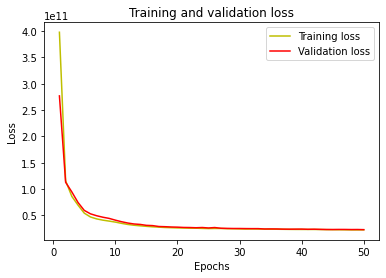

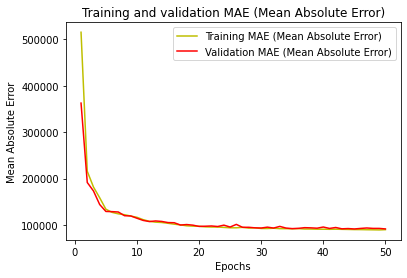

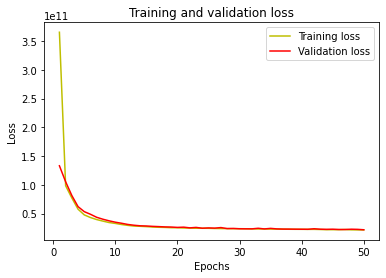

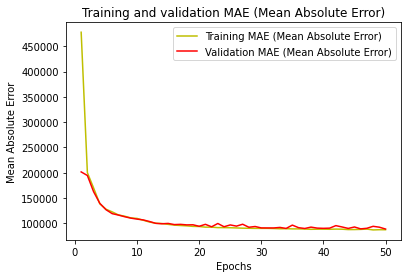

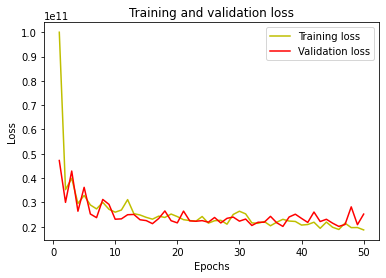

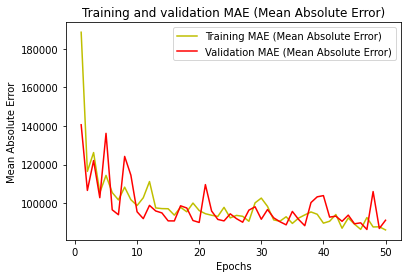

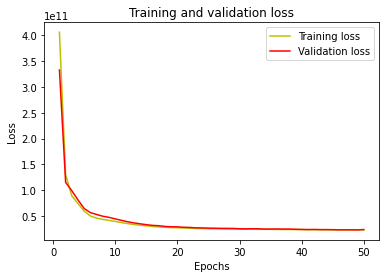

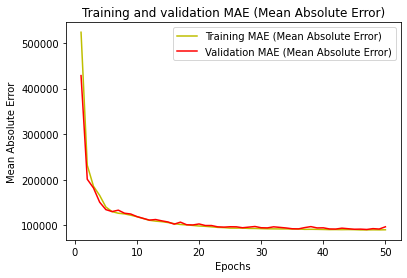

In [62]:
# plot loss graph for training and validation dataset
# plot MAE graph for training and validation dataset
for i in results_list:
  plotLoss(i)
  plotAccuracy(i)

**Using candidate models to predict output and compare their performance**

In [63]:
yPred1 = model1.predict(xTestScaled)
# check the prediction and actual value
yTest.reset_index(drop=True, inplace=True)
compareToActual1 = pd.concat([yTest, pd.DataFrame(yPred1)], axis = 1 )
print("Actual price compare with Predicted Price with Model 1")
print(compareToActual1)


Actual price compare with Predicted Price with Model 1
         price              0
0     692500.0  611422.562500
1     343000.0  381894.250000
2     580000.0  468523.312500
3     249000.0  257928.453125
4     560000.0  547956.937500
...        ...            ...
6479  426950.0  359447.375000
6480  475000.0  467219.750000
6481  579950.0  484546.875000
6482  205000.0  169415.921875
6483  300000.0  414997.937500

[6484 rows x 2 columns]


In [64]:
yPred2 = model2.predict(xTestScaled)
# check the prediction and actual value
yTest.reset_index(drop=True, inplace=True)
compareToActual2 = pd.concat([yTest, pd.DataFrame(yPred2)], axis = 1 )
print("Actual price compare with Predicted Price with Model 2")
print(compareToActual2)


Actual price compare with Predicted Price with Model 2
         price              0
0     692500.0  621740.937500
1     343000.0  362544.218750
2     580000.0  461785.750000
3     249000.0  251401.640625
4     560000.0  565741.687500
...        ...            ...
6479  426950.0  367827.031250
6480  475000.0  483662.968750
6481  579950.0  481163.250000
6482  205000.0  184918.390625
6483  300000.0  422288.875000

[6484 rows x 2 columns]


In [65]:
yPred3 = model3.predict(xTestScaled)
# check the prediction and actual value
yTest.reset_index(drop=True, inplace=True)
compareToActual3 = pd.concat([yTest, pd.DataFrame(yPred3)], axis = 1 )
print("Actual price compare with Predicted Price with Model 3")
print(compareToActual3)


Actual price compare with Predicted Price with Model 3
         price              0
0     692500.0  573650.937500
1     343000.0  389614.656250
2     580000.0  472830.218750
3     249000.0  225850.125000
4     560000.0  552807.687500
...        ...            ...
6479  426950.0  375177.062500
6480  475000.0  483457.187500
6481  579950.0  458136.187500
6482  205000.0  225850.109375
6483  300000.0  420925.312500

[6484 rows x 2 columns]


In [66]:
yPred4 = model4.predict(xTestScaled)
# check the prediction and actual value
yTest.reset_index(drop=True, inplace=True)
compareToActual4 = pd.concat([yTest, pd.DataFrame(yPred4)], axis = 1 )
print("Actual price compare with Predicted Price with Model 4")
print(compareToActual4)

Actual price compare with Predicted Price with Model 4
         price             0
0     692500.0  644633.50000
1     343000.0  409939.68750
2     580000.0  501246.53125
3     249000.0  290741.71875
4     560000.0  594627.75000
...        ...           ...
6479  426950.0  403390.84375
6480  475000.0  527366.81250
6481  579950.0  504016.28125
6482  205000.0  195386.53125
6483  300000.0  459155.87500

[6484 rows x 2 columns]


In [67]:
# Evaluation report for Tunned Model
print(" Model 1 Performance Evaluation")
modelEvaluationReport(yTest, yPred1 )
print(" Model 2 Performance Evaluation")
modelEvaluationReport(yTest, yPred2 )
print(" Model 3 Performance Evaluation")
modelEvaluationReport(yTest, yPred3 )
print(" Model 4 Performance Evaluation")
modelEvaluationReport(yTest, yPred4 )

 Model 1 Performance Evaluation
 The results with hyperparameters tunning
The Mean Absolute Error   : 90814.691
The Mean Squared Error    : 22164037647.659
The Root Mean Square Error: 148875.914
 Model 2 Performance Evaluation
 The results with hyperparameters tunning
The Mean Absolute Error   : 88700.780
The Mean Squared Error    : 21890913840.871
The Root Mean Square Error: 147955.783
 Model 3 Performance Evaluation
 The results with hyperparameters tunning
The Mean Absolute Error   : 89648.741
The Mean Squared Error    : 24944217854.805
The Root Mean Square Error: 157937.386
 Model 4 Performance Evaluation
 The results with hyperparameters tunning
The Mean Absolute Error   : 95332.367
The Mean Squared Error    : 23138467225.926
The Root Mean Square Error: 152113.337


 Model 1


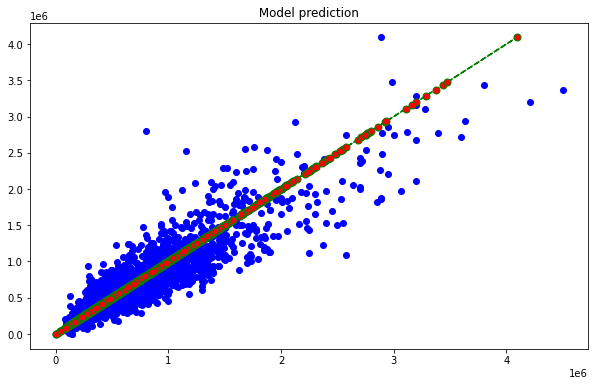

 Model 2


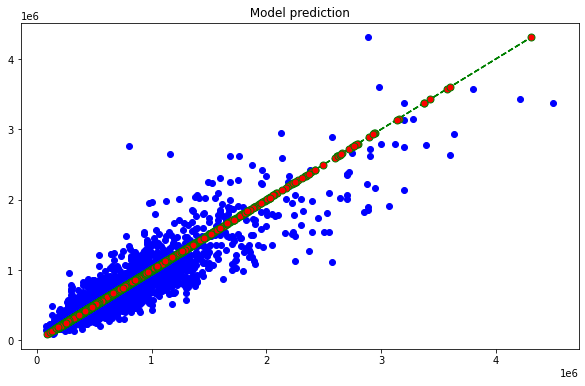

 Model 3


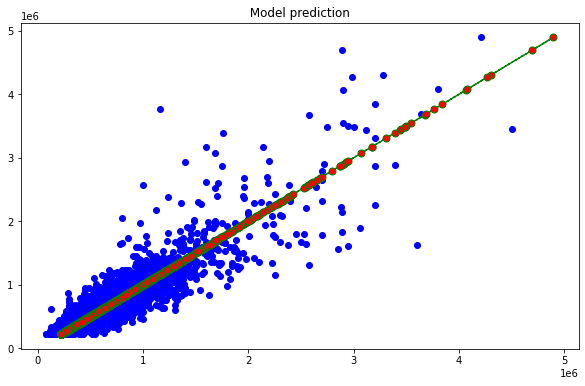

 Model 4


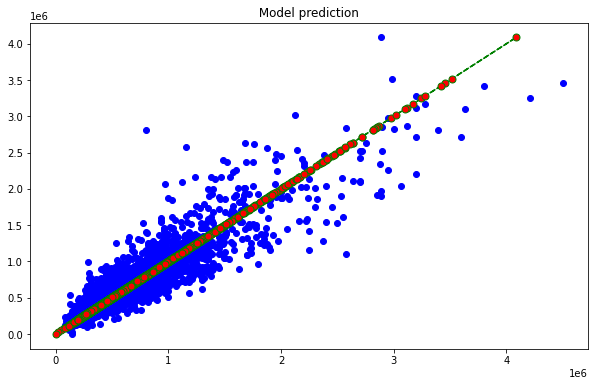

In [68]:
#plot the results of 4 different models
print(" Model 1")
plotResult(yTest, yPred1)
print(" Model 2")
plotResult(yTest, yPred2)
print(" Model 3")
plotResult(yTest, yPred3)
print(" Model 4")
plotResult(yTest, yPred4)

# **Reference**

**Auther :** 

Chayanin Chomchuen

**Co-auther :** 

Sabarinath Muralidharan Sujatha